In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential

2023-08-31 02:14:40.361011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 02:14:44.643925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-31 02:14:49.708381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-31 02:14:51.208627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-31 02:14:51.209014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
data = pd.read_csv("train.csv")
data['comment_text'] = data['comment_text'].str.lower()
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
labels = ['threat', 'severe_toxic','identity_hate','obscene', 'threat', 'insult']

balanced_train_data = pd.DataFrame() 

for column in labels:
    minority_comments = train_data[train_data[column] == 1]
    majority_comments = train_data[train_data[column] == 0]
    
    minority_upsampled = resample(minority_comments,
                                   replace=True,
                                   n_samples=len(majority_comments),
                                   random_state=42)
    
    balanced_train_data = pd.concat([balanced_train_data, majority_comments, minority_upsampled])

balanced_train_data = balanced_train_data.sample(frac=1, random_state=42)
len(balanced_train_data)

1499492

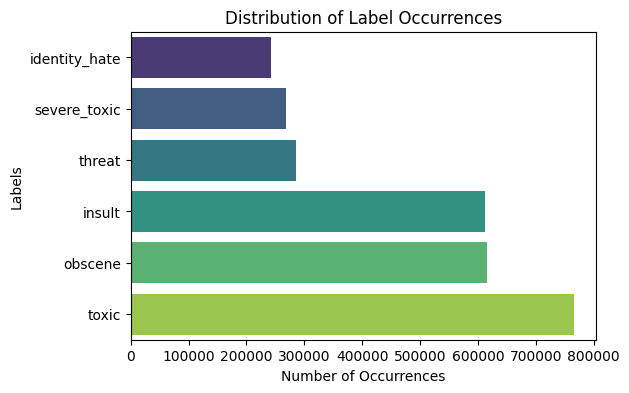

[242422 267868 284988 611921 616176 765436]


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

column_labels = balanced_train_data.columns.tolist()[2:]
label_counts = balanced_train_data[column_labels].sum().sort_values()

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')

plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')
plt.show()
print(label_counts.values)

/tmp/ipykernel_1493/3878667735.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_toxic = balanced_train_data[train_data[column_labels].sum(axis=1) > 0]
/tmp/ipykernel_1493/3878667735.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_clean = balanced_train_data[train_data[column_labels].sum(axis=1) == 0]


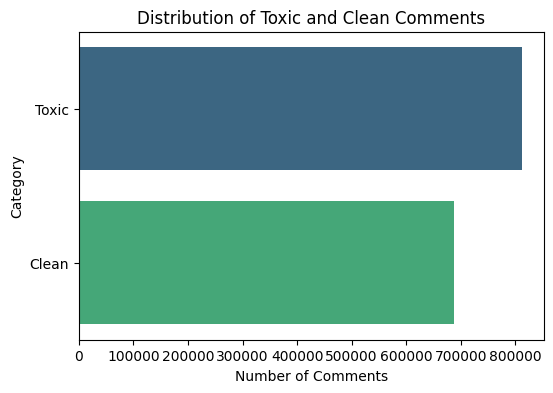

In [6]:
train_toxic = balanced_train_data[train_data[column_labels].sum(axis=1) > 0]
train_clean = balanced_train_data[train_data[column_labels].sum(axis=1) == 0]

num_toxic = len(train_toxic)
num_clean = len(train_clean)

plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize=(6, 4))

ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')

plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

ax.tick_params()

plt.show()

In [7]:
max_words = 10000  # Number of words in your vocabulary
max_seq_length = 150  # Maximum sequence length for padding

In [8]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(balanced_train_data['comment_text'])

In [9]:
train_sequences = tokenizer.texts_to_sequences(balanced_train_data['comment_text'])
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_seq_length)

test_sequences = tokenizer.texts_to_sequences(test_data['comment_text'])
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_seq_length)

In [10]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences_padded, balanced_train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(balanced_train_data))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(8) 

2023-08-31 02:16:24.010461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-31 02:16:24.010770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-31 02:16:24.010935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
embedding_dim = 100
stop_early = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'), 
    Dense(6, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 3
model.fit(train_dataset, epochs=epochs, callbacks = [stop_early])

2023-08-31 02:16:32.492274: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 899695200 exceeds 10% of free system memory.
2023-08-31 02:16:32.744148: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 71975616 exceeds 10% of free system memory.


Epoch 1/3


2023-08-31 02:16:47.191990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 262995 of 1499492
2023-08-31 02:16:57.198294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 264098 of 1499492
2023-08-31 02:17:07.192865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 265187 of 1499492
2023-08-31 02:17:17.199970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 266286 of 1499492
2023-08-31 02:17:27.192386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 267446 of 1499492
2023-08-31 02:17:37.199618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 524468 of 1499492
2023-08-31 02:17:47.196560: I tensorflow/core/kernels/data/shuffle_dat

46860/46860 [==============================] - 1167s 17ms/step - loss: 0.1238 - accuracy: 0.8814
Epoch 2/3
46860/46860 [==============================] - 639s 14ms/step - loss: 0.0371 - accuracy: 0.8807
Epoch 3/3
46860/46860 [==============================] - 559s 12ms/step - loss: 0.0225 - accuracy: 0.8972


In [12]:
predictions = model.predict(test_sequences_padded)
rounded_predictions = np.round(predictions)

print(classification_report(test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], rounded_predictions))

998/998 [==============================] - 5s 4ms/step
              precision    recall  f1-score   support

           0       0.81      0.69      0.75      3056
           1       0.36      0.41      0.38       321
           2       0.77      0.75      0.76      1715
           3       0.40      0.34      0.36        74
           4       0.67      0.62      0.64      1614
           5       0.42      0.33      0.37       294

   micro avg       0.72      0.66      0.69      7074
   macro avg       0.57      0.52      0.54      7074
weighted avg       0.73      0.66      0.69      7074
 samples avg       0.06      0.06      0.06      7074



/home/krrish/.conda/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krrish/.conda/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


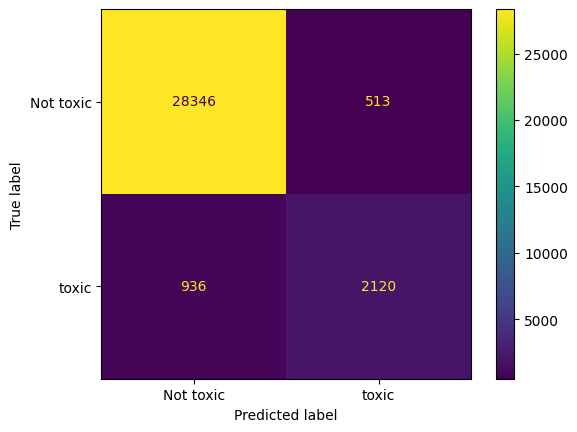

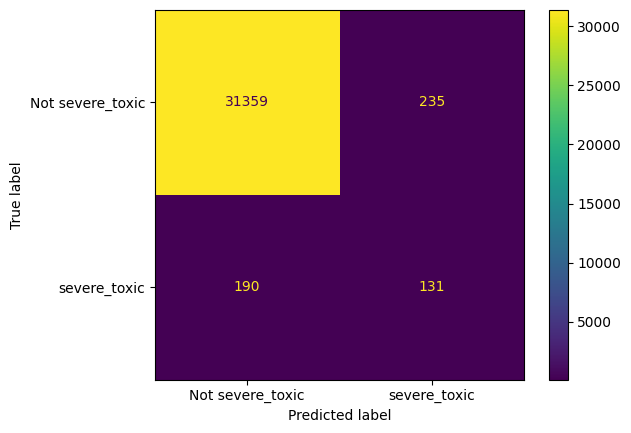

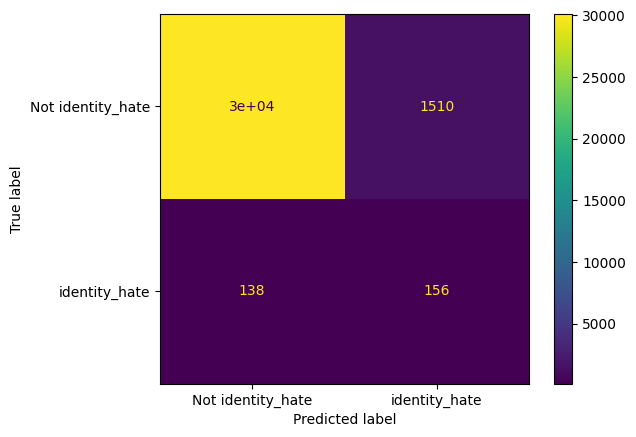

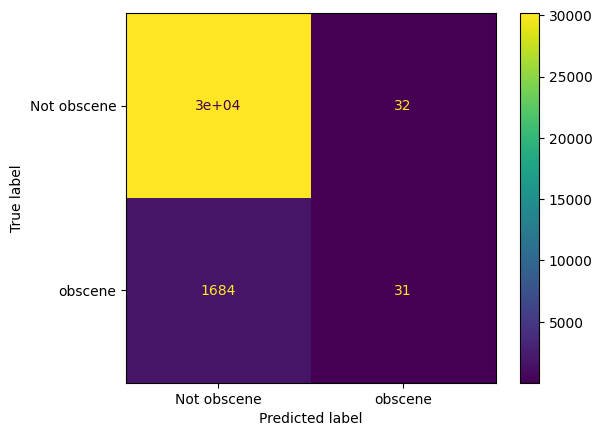

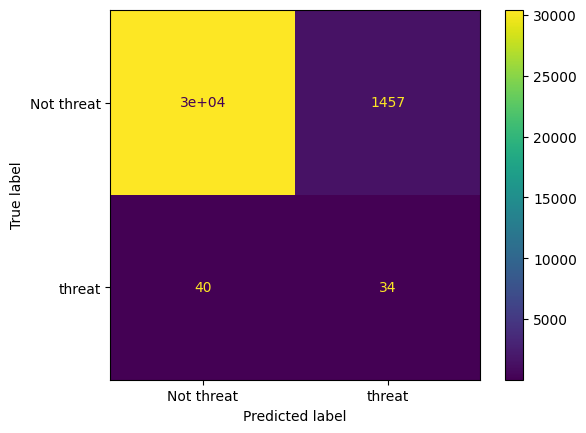

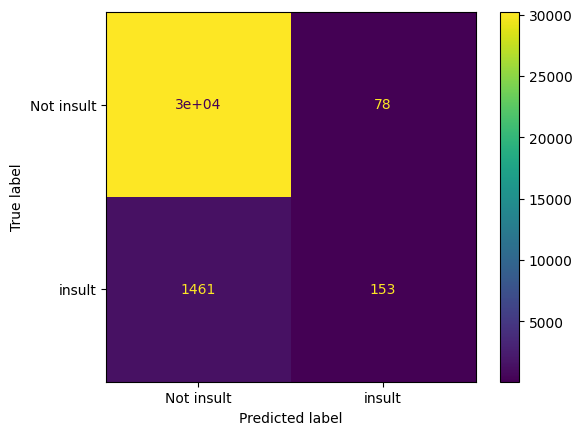

In [13]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

labels = ['toxic', 'severe_toxic','identity_hate','obscene', 'threat', 'insult']

for i in range(6):
    conf_matrix = confusion_matrix(test_data[labels[i]], rounded_predictions[:,i])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=[f"Not {labels[i]}",f"{labels[i]}"])
    cm_display.plot()

In [14]:
def predict_toxicity(model, sentence):
    sentence = sentence.lower() 
    sentence_sequence = tokenizer.texts_to_sequences([sentence])
    sentence_sequence_padded = pad_sequences(sentence_sequence, maxlen=max_seq_length)

    predictions = model.predict(sentence_sequence_padded)
    predicted_labels = [True if prediction >= 0.5 else False for prediction in predictions[0]]

    for label, prediction in zip(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], predicted_labels):
        if(prediction):
            print(f"{label.capitalize()}")

In [15]:
test_sentence = "Fuck your nigger ass"

predict_toxicity(model, test_sentence)

1/1 [==============================] - 0s 130ms/step
Toxic
Severe_toxic
Obscene
Insult
Identity_hate
